<a href="https://colab.research.google.com/github/luizmv8080/aprendizaje-profundo/blob/main/Tarea1/Ejercicio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Red completamente conectada con PyTorch

In [2]:
import random
from itertools import islice as take
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from skimage import io
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.auto import trange

In [43]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

In [44]:
# creamos un Dataset
ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # convertir la imagen a ndarray
    transform=np.array,
    # descargar el conjunto
    download=True
)

## Conjunto de entrenamiento

In [45]:
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

## Conjunto de prueba

In [46]:
# Creamos un Dataset
tst_ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

## Arquitectura para solo una capa oculta y funcion de activacion Relu

In [47]:
# definición del modelo de una capa
class FCNOneRelu(nn.Module):

    # inicializador
    def __init__(self,n_capa1):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = n_capa1, 10

        # definición de capas
        self.cls = nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            nn.Linear(FC1, FC2)
        )

    # método para inferencia
    def forward(self, x):
        x = self.cls(x)
        return x

## Arquitectura para solo una capa oculta y funcion de activacion Sigmoide

In [48]:
# definición del modelo de una capa
class FCNOneSigmoi(nn.Module):

    # inicializador
    def __init__(self,n_capa1):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = n_capa1, 10

        # definición de capas
        self.cls = nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),
            nn.Linear(FC1, FC2)
        )

    # método para inferencia
    def forward(self, x):
        x = self.cls(x)
        return x

## Arquitectura para dos capas ocultas y funcion de activacion Relu

In [49]:
# definición del modelo de una capa
class FCNTwoRelu(nn.Module):

    # inicializador
    def __init__(self,n_capa1,n_capa2):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = n_capa1, n_capa2

        # definición de capas
        self.cls = nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            nn.Linear(FC1, FC2),
            nn.ReLU(),
            nn.Linear(FC2, 10)

        )

    # método para inferencia
    def forward(self, x):
        x = self.cls(x)
        return x

## Arquitectura para dos capas ocultas y funcion de activacion Sigmoide

In [50]:
# definición del modelo de una capa
class FCNTwoSigmoi(nn.Module):

    # inicializador
    def __init__(self,n_capa1,n_capa2):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = n_capa1, n_capa2

        # definición de capas
        self.cls = nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),
            nn.Linear(FC1, FC2),
            nn.Sigmoid(),
            nn.Linear(FC2, 10)

        )

    # método para inferencia
    def forward(self, x):
        x = self.cls(x)
        return x

## Funcion para entrenar modelo

In [51]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        if epoch == (epochs -1):
          print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

## Haciendo pruebas para encontrar el numero de neuronas optimos para el modelo de solo una capa

In [23]:
n_capas_1 = [128,100,50]

for i in n_capas_1:
  model = FCNOneRelu(i)
  print("Para un numero de neuronas de {0} en la capa oculta, se tiene: ".format(i))
  loss_hist, acc_hist = train(model, trn_dl, tst_dl)
  print("=====================================")

Para un numero de neuronas de 128 en la capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 33.84, 32.30] acc=[90.56,90.83]
Para un numero de neuronas de 100 en la capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 33.75, 32.28] acc=[90.50,90.88]
Para un numero de neuronas de 50 en la capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 34.69, 33.16] acc=[90.31,90.68]


In [24]:
for i in n_capas_1:
  model = FCNOneSigmoi(i)
  print("Para un numero de neuronas de {0} en la capa oculta, se tiene: ".format(i))
  loss_hist, acc_hist = train(model, trn_dl, tst_dl)
  print("=====================================")

Para un numero de neuronas de 128 en la capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 73.33, 71.53] acc=[83.78,84.43]
Para un numero de neuronas de 100 en la capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 76.00, 74.21] acc=[83.53,84.13]
Para un numero de neuronas de 50 en la capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 83.82, 82.48] acc=[81.99,82.48]


## Haciendo pruebas para encontrar el numero de neuronas para cada capa del modelo de dos capas ocultas

In [25]:
n_capas_2 = [50,20]

for i in n_capas_1:
  for j in n_capas_2:
    model = FCNTwoRelu(i,j)
    print("Para un numero de neuronas de {0} en la primera capa oculta y {1} en la segunda capa oculta, se tiene: ".format(i,j))
    loss_hist, acc_hist = train(model, trn_dl, tst_dl)
    print("=====================================")

Para un numero de neuronas de 128 en la primera capa oculta y 50 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 33.12, 31.66] acc=[90.51,90.72]
Para un numero de neuronas de 128 en la primera capa oculta y 20 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 33.59, 32.29] acc=[90.47,90.67]
Para un numero de neuronas de 100 en la primera capa oculta y 50 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 33.12, 32.04] acc=[90.59,90.76]
Para un numero de neuronas de 100 en la primera capa oculta y 20 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 34.26, 33.14] acc=[90.29,90.33]
Para un numero de neuronas de 50 en la primera capa oculta y 50 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 34.06, 32.96] acc=[90.30,90.58]
Para un numero de neuronas de 50 en la primera capa oculta y 20 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 35.82, 34.50] acc=[89.80,89.93]


In [26]:
for i in n_capas_1:
  for j in n_capas_2:
    model = FCNTwoSigmoi(i,j)
    print("Para un numero de neuronas de {0} en la primera capa oculta y {1} en la segunda capa oculta, se tiene: ".format(i,j))
    loss_hist, acc_hist = train(model, trn_dl, tst_dl)
    print("=====================================")

Para un numero de neuronas de 128 en la primera capa oculta y 50 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[225.98,225.87] acc=[22.67,22.87]
Para un numero de neuronas de 128 en la primera capa oculta y 20 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[225.99,225.91] acc=[24.24,24.08]
Para un numero de neuronas de 100 en la primera capa oculta y 50 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[224.92,224.79] acc=[26.19,26.57]
Para un numero de neuronas de 100 en la primera capa oculta y 20 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[227.21,227.14] acc=[14.46,14.99]
Para un numero de neuronas de 50 en la primera capa oculta y 50 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[227.34,227.30] acc=[12.58,12.72]
Para un numero de neuronas de 50 en la primera capa oculta y 20 en la segunda capa oculta, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[226.34,226.22] acc=[21.25,21.70]


## Haciendo pruebas con el lr para mejorar el modelo

Para el **modelo de una capa**, sin duda el desempeño mejora con una capa de **128 neuronas** y funcion **Relu** de activacion, por lo que en este caso, vamos a variar el learning rate para ver que tanto puede mejorar:

In [29]:
lr = [0.05,0.005]

for i in lr:
  model = FCNOneRelu(128)
  print("Para un lr de {0}, se tiene: ".format(i))
  loss_hist, acc_hist = train(model, trn_dl, tst_dl,lr=i)
  print("=====================================")

Para un lr de 0.05, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[  2.52,  6.81] acc=[99.44,97.88]
Para un lr de 0.005, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 19.33, 19.20] acc=[94.60,94.55]


Para el **modelo de dos capas**, la forma mas optima es **100** neuronas en la **primera capa** y **50** en la **segunda** con funciones de activacion Relu en las dos, ahora variaremos el learning rate:

In [31]:
for i in lr:
  model = FCNTwoRelu(100,50)
  print("Para un lr de {0}, se tiene: ".format(i))
  loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=i)
  print("=====================================")

Para un lr de 0.05, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[  0.79,  8.03] acc=[99.83,97.76]
Para un lr de 0.005, se tiene: 


  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 14.40, 15.10] acc=[95.85,95.59]


Vemos que para el **modelo de una capa** el **lr** optimo es de **0.05**, y para el modelo de **dos capas** el **lr** optimo es tambien de **0.05**.

## Creando nuestros modelos con los parametros optimos

#### Modelo de una capa

In [56]:
modelo_una_capa = FCNOneRelu(128)
loss_hist_m1, acc_hist_m1 = train(modelo_una_capa, trn_dl, tst_dl, lr =0.05)

  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[  2.53,  6.86] acc=[99.42,97.88]


In [57]:
modelo_dos_capas = FCNTwoRelu(100,50)
loss_hist_m2, acc_hist_m2 = train(modelo_dos_capas, trn_dl, tst_dl, lr =0.05)

  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[  0.54,  7.84] acc=[99.92,97.98]


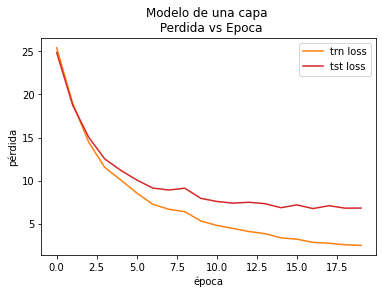

In [58]:
trn_loss_m1, tst_loss_m1 = zip(*loss_hist_m1)
plt.plot(trn_loss_m1, 'tab:orange', label='trn loss')
plt.plot(tst_loss_m1, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.title('Modelo de una capa \n Perdida vs Epoca')
plt.show()

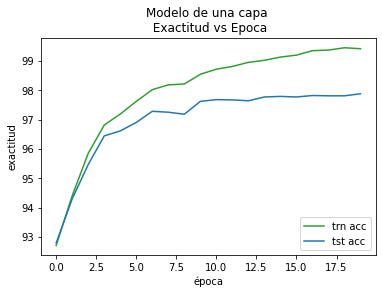

In [59]:
trn_acc_m1, tst_acc_m1 = zip(*acc_hist_m1)
plt.plot(trn_acc_m1, 'tab:green', label='trn acc')
plt.plot(tst_acc_m1, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.title('Modelo de una capa \n Exactitud vs Epoca')
plt.show()

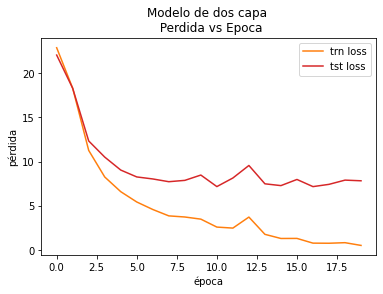

In [60]:
trn_loss_m2, tst_loss_m2 = zip(*loss_hist_m2)
plt.plot(trn_loss_m2, 'tab:orange', label='trn loss')
plt.plot(tst_loss_m2, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.title('Modelo de dos capa \n Perdida vs Epoca')
plt.show()

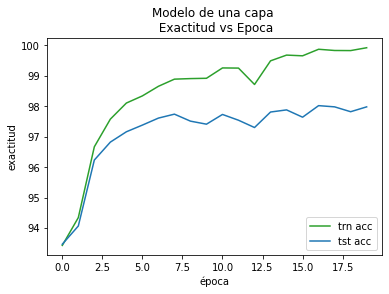

In [61]:
trn_acc_m2, tst_acc_m2 = zip(*acc_hist_m2)
plt.plot(trn_acc_m2, 'tab:green', label='trn acc')
plt.plot(tst_acc_m2, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.title('Modelo de una capa \n Exactitud vs Epoca')
plt.show()

Vemos que en los dos modelos hay **sobreajuste**, por lo que aunque los parametros elejidos dan una exactitud **mayor al 99%** al momento de probar el modelo en datos de prueba hay un poco de **sobreajuste**. Por lo que mejor se elejira un lr de **0.01**.

In [62]:
modelo_una_capa = FCNOneRelu(128)
loss_hist_m1, acc_hist_m1 = train(modelo_una_capa, trn_dl, tst_dl, lr =0.01)

  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[ 11.78, 12.81] acc=[96.75,96.35]


In [63]:
modelo_dos_capas = FCNTwoRelu(100,50)
loss_hist_m2, acc_hist_m2 = train(modelo_dos_capas, trn_dl, tst_dl, lr =0.01)

  0%|          | 0/20 [00:00<?, ?it/s]

E19 loss=[  7.31,  9.69] acc=[98.00,97.25]


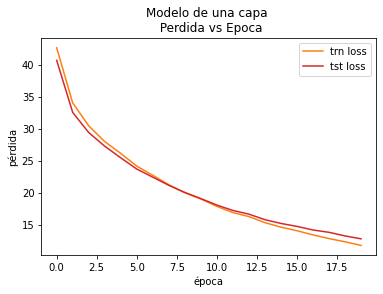

In [64]:
trn_loss_m1, tst_loss_m1 = zip(*loss_hist_m1)
plt.plot(trn_loss_m1, 'tab:orange', label='trn loss')
plt.plot(tst_loss_m1, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.title('Modelo de una capa \n Perdida vs Epoca')
plt.show()

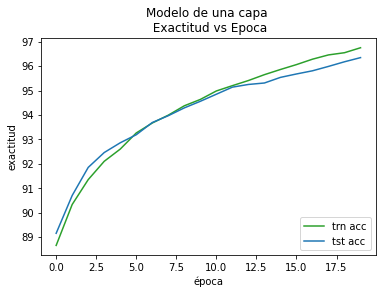

In [65]:
trn_acc_m1, tst_acc_m1 = zip(*acc_hist_m1)
plt.plot(trn_acc_m1, 'tab:green', label='trn acc')
plt.plot(tst_acc_m1, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.title('Modelo de una capa \n Exactitud vs Epoca')
plt.show()

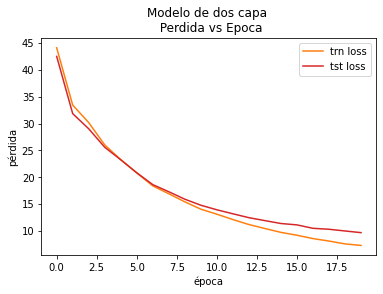

In [66]:
trn_loss_m2, tst_loss_m2 = zip(*loss_hist_m2)
plt.plot(trn_loss_m2, 'tab:orange', label='trn loss')
plt.plot(tst_loss_m2, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.title('Modelo de dos capa \n Perdida vs Epoca')
plt.show()

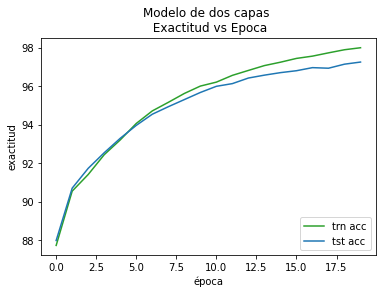

In [68]:
trn_acc_m2, tst_acc_m2 = zip(*acc_hist_m2)
plt.plot(trn_acc_m2, 'tab:green', label='trn acc')
plt.plot(tst_acc_m2, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.title('Modelo de dos capas \n Exactitud vs Epoca')
plt.show()

Vemos que con un **lr** de **0.001** el sobreajuste disminuye y se tiene una exactitud arriba del **96%** para ambos modelos.